# Confidence Intervals

This notebook overviews scalecast intervals, which are scored with [Mean Scaled Interval Score (MSIS)](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis). Lower scores are better. This notebook requires `scalecast>=0.17.0`.  

Scalecast uses a naive conformal interval, created from holding out a test-set of data and setting interval ranges from the percentiles of the test-set residuals. This simple approach allows every estimator type to get the same kind of interval. As we will see by scoring the intervals and comparing them to ARIMA intervals from statsmodels, the results are good.  

To evaluate the intervals, we leave out a section of each series to score out-of-sample. This is usually not necessary for scalecast, as all models are tested automatically, but the confidence intervals can overfit on any test set stored in the `Forecaster` or `MVForecaster` object due to leakage that occurs when constructing these intervals. Scalecast intervals are compared to ARIMA intervals on the same series in the last section of this notebook and the scalecast intervals, on the whole, perform better. The series used in this example are ordered from easiest-to-hardest to forecast.  

[Easy Distribution-Free Conformal Intervals for Time Series](https://medium.com/towards-data-science/easy-distribution-free-conformal-intervals-for-time-series-665137e4d907)  

**Sections:**  
[Daily Website Visitors](#Daily-Website-Visitors)  
[Housing Starts](#Housing-Starts)  
[Avocado Sales](#Avocado-Sales)  
[All Aggregated Results](#All-Aggregated-Results)  
[Benchmark Against StatsModels ARIMA](#Benchmark-Against-StatsModels-ARIMA)  

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import metrics
from scalecast.notebook import tune_test_forecast
from scalecast.SeriesTransformer import SeriesTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
models = (
    'mlr',
    'elasticnet',
    'ridge',
    'knn',
    'xgboost',
    'lightgbm',
    'gbt',
) # these are all scikit-learn models or APIs
# this will be used later to fill in results
results_template = pd.DataFrame(index=models)

In [4]:
def score_cis(results, fcsts, ci_name, actuals, obs, val_len, models=models, m_=1):
    for m in models:
        results.loc[m,ci_name] = metrics.msis(
            a = actuals,
            uf = fcsts[m+'_upperci'],
            lf = fcsts[m+'_lowerci'],
            obs = obs,
            m = m_,
        )
    return results

In [5]:
GridGenerator.get_example_grids()

## Daily Website Visitors

- Link to data: https://www.kaggle.com/datasets/bobnau/daily-website-visitors  
- We will use a length of 180 observations (about half a year) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 60-day forecast horizon  

In [6]:
val_len = 180
fcst_len = 60

In [7]:
data = pd.read_csv('daily-website-visitors.csv',parse_dates=['Date']).set_index('Date')
data.head()

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,"2,146","1,582",1430,152
2014-09-15,2,Monday,2,"3,621","2,528",2297,231
2014-09-16,3,Tuesday,3,"3,698","2,630",2352,278
2014-09-17,4,Wednesday,4,"3,667","2,614",2327,287
2014-09-18,5,Thursday,5,"3,316","2,366",2130,236


In [8]:
visits_sep = data['First.Time.Visits'].iloc[-fcst_len:]
visits = data['First.Time.Visits'].iloc[:-fcst_len]

In [9]:
f=Forecaster(
    y=visits,
    current_dates=visits.index,
    future_dates=fcst_len,
    test_length = val_len,
    validation_length = val_len, # for hyperparameter tuning
    cis = True, # set to True at initialization to always evaluate cis
)
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-06-20T00:00:00.000000000
    Freq=D
    N_actuals=2107
    ForecastLength=60
    Xvars=['t', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98', 'AR99', 'AR100']
    Differenced=0
    TestLe

In [10]:
tune_test_forecast(
    f,
    models,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
ms = f.export('model_summaries',determine_best_by='TestSetRMSE')
ms[['ModelNickname','TestSetRMSE','InSampleRMSE']]

,ModelNickname,TestSetRMSE,InSampleRMSE
0,xgboost,532.374846,15.360314
1,lightgbm,582.261645,112.543232
2,elasticnet,799.517909,185.961252
3,knn,799.926636,313.511695
4,ridge,800.686503,186.169323
5,mlr,803.931314,185.620629
6,gbt,1163.825383,147.478748


We will demonstrate how the confidence intervals change as they are re-evaluated using the best model according to the test RMSE.

### Evaluate Interval

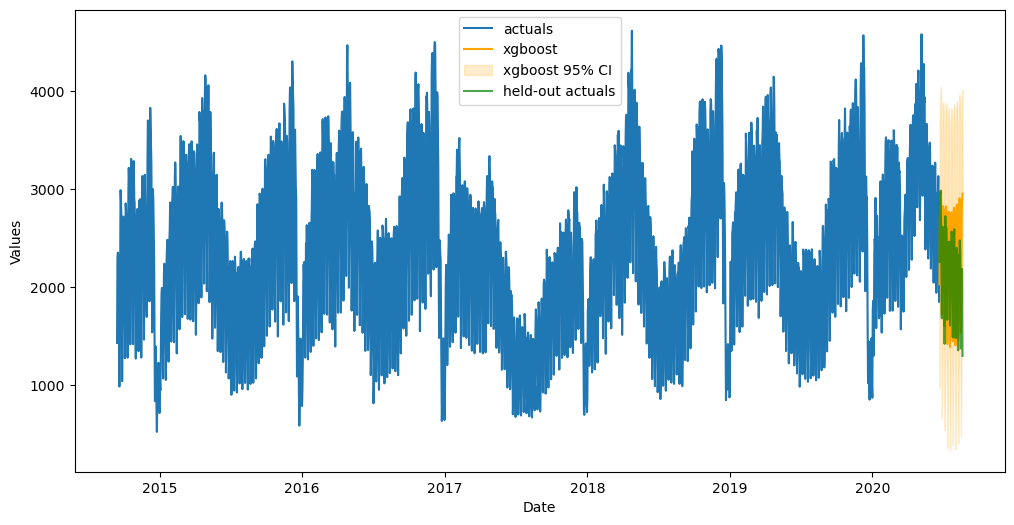

In [12]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models='top_1',order_by='TestSetRMSE',ax=ax)
sns.lineplot(
    y = 'First.Time.Visits',
    x = 'Date',
    data = visits_sep.reset_index(),
    ax = ax,
    label = 'held-out actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [13]:
# export test-set preds and confidence intervals
fcsts1 = f.export("lvl_fcsts",cis=True)
fcsts1.head()

,DATE,mlr,mlr_upperci,mlr_lowerci,elasticnet,elasticnet_upperci,elasticnet_lowerci,ridge,ridge_upperci,ridge_lowerci,...,knn_lowerci,xgboost,xgboost_upperci,xgboost_lowerci,lightgbm,lightgbm_upperci,lightgbm_lowerci,gbt,gbt_upperci,gbt_lowerci
0,2020-06-21,2190.555279,3464.907755,916.202804,2199.951838,3467.503088,932.400587,2191.032219,3458.193296,923.871142,...,798.566667,2028.825562,3087.674011,969.977112,2198.858468,3232.664729,1165.052207,2125.968510,4025.426281,226.510740
1,2020-06-22,2835.674158,4110.026633,1561.321683,2837.629387,4105.180638,1570.078137,2833.176793,4100.337870,1566.015716,...,1680.233333,2720.898438,3779.746887,1662.049988,2820.575637,3854.381898,1786.769376,2729.050006,4628.507777,829.592236
2,2020-06-23,2975.510723,4249.863198,1701.158248,2963.220499,4230.771750,1695.669249,2973.276499,4240.437576,1706.115422,...,1756.185714,2845.472412,3904.320862,1786.623962,2819.654176,3853.460437,1785.847915,2900.134825,4799.592596,1000.677054
3,2020-06-24,3038.258157,4312.610632,1763.905681,3026.889266,4294.440516,1759.338015,3036.083100,4303.244177,1768.922023,...,1846.185714,2904.729492,3963.577942,1845.881042,2824.992206,3858.798467,1791.185945,2930.293895,4829.751666,1030.836125
4,2020-06-25,3032.580568,4306.933043,1758.228093,3024.266925,4291.818176,1756.715675,3025.321967,4292.483044,1758.160890,...,1514.947619,2986.020996,4044.869446,1927.172546,2961.588543,3995.394805,1927.782282,3029.007375,4928.465146,1129.549604


The values in the below table are [mean scaled interval scores](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis) for confidence intervals. Lower scores are better.

In [14]:
results = score_cis(
    results_template.copy(),
    fcsts1,
    'Daily Visitors',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Daily Visitors
mlr,5.632456
elasticnet,5.594578
ridge,5.609157
knn,5.626693
xgboost,5.520301
lightgbm,5.196714
gbt,8.337301


## Housing Starts  

- Link to data: https://fred.stlouisfed.org/series/HOUSTNSA  
- We will use a length of 96 observations (8 years) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 24-month forecast horizon  

In [15]:
import pandas_datareader as pdr

In [16]:
val_len = 96
fcst_len = 24

In [17]:
housing = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2021-06-01')
housing.head()

,HOUSTNSA
DATE,
1959-01-01,96.2
1959-02-01,99.0
1959-03-01,127.7
1959-04-01,150.8
1959-05-01,152.5


In [18]:
starts_sep = housing.iloc[-fcst_len:,0]
starts = housing.iloc[:-fcst_len,0]

In [19]:
f = Forecaster(
    y=starts,
    current_dates=starts.index,
    future_dates=fcst_len,
    test_length=val_len,
    validation_length=val_len,
    cis=True,
)
# difference the data for stationary modeling
transformer = SeriesTransformer(f)
f = transformer.DiffTransform(1)
# find best xvars to forecast with
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=1959-02-01T00:00:00.000000000
    DateEndActuals=2019-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=725
    ForecastLength=24
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98'

In [20]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
# rever the difftransform
f = transformer.DiffRevert(1)

In [22]:
ms = f.export('model_summaries',determine_best_by='TestSetRMSE')
ms[['ModelNickname','TestSetRMSE','InSampleRMSE']]

,ModelNickname,TestSetRMSE,InSampleRMSE
0,xgboost,21.453199,3.112793
1,lightgbm,22.903613,27.660879
2,mlr,29.967949,71.624715
3,knn,43.350231,146.502991
4,ridge,45.733790,55.969584
5,elasticnet,53.157531,38.237499
6,gbt,78.527199,35.791310


### Evaluate Interval

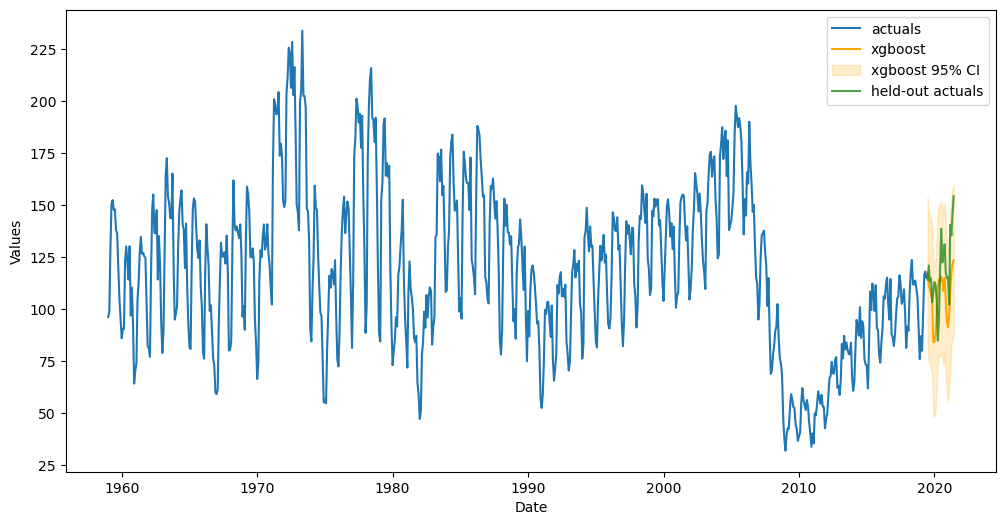

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models='top_1',order_by='TestSetRMSE',ax=ax)
sns.lineplot(
    y = 'HOUSTNSA',
    x = 'DATE',
    data = starts_sep.reset_index(),
    ax = ax,
    label = 'held-out actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [24]:
housing_fcsts1 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    results_template.copy(),
    housing_fcsts1,
    'Housing Starts',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12, # monthly seasonality
)
housing_results

,Housing Starts
mlr,5.657050
elasticnet,8.238805
ridge,7.299241
knn,6.788912
xgboost,3.924839
lightgbm,4.289493
gbt,12.670211


In [25]:
results['Housing Starts'] = housing_results['Housing Starts']
results

,Daily Visitors,Housing Starts
mlr,5.632456,5.657050
elasticnet,5.594578,8.238805
ridge,5.609157,7.299241
knn,5.626693,6.788912
xgboost,5.520301,3.924839
lightgbm,5.196714,4.289493
gbt,8.337301,12.670211


## Avocado Sales  

- Link to data: https://www.kaggle.com/datasets/neuromusic/avocado-prices  
- We will use a length of 20 observations both to tune and test the models (95% CIs require at least 20 observations in the test set)  
- We want to optimize the forecasts and confidence intervals for a 20-week forecast horizon  

In [26]:
# change display settings
pd.options.display.float_format = '{:,.2f}'.format

In [27]:
val_len = 20
fcst_len = 20

In [28]:
avocados = pd.read_csv('avocado.csv',parse_dates = ['Date'])
volume = avocados.groupby('Date')['Total Volume'].sum()

In [29]:
volume.reset_index().head()

,Date,Total Volume
0,2015-01-04,"84,674,337.20"
1,2015-01-11,"78,555,807.24"
2,2015-01-18,"78,388,784.08"
3,2015-01-25,"76,466,281.07"
4,2015-02-01,"119,453,235.25"


In [30]:
volume_sep = volume.iloc[-fcst_len:]
volume = volume.iloc[:-fcst_len]

In [31]:
f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = fcst_len,
    test_length = val_len,
    validation_length = val_len,
    cis = True,
)

# difference the data for stationary modeling
transformer = SeriesTransformer(f)
f = transformer.DiffTransform(1)
f = transformer.DiffTransform(52) # seasonal differencing
# find best xvars
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=26,
    monitor='ValidationMetricValue', # not test set
    decomp_trend=False,
)
f

Forecaster(
    DateStartActuals=2016-01-10T00:00:00.000000000
    DateEndActuals=2017-11-05T00:00:00.000000000
    Freq=W-SUN
    N_actuals=96
    ForecastLength=20
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9']
    Differenced=0
    TestLength=20
    ValidationLength=20
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [32]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [33]:
# revert differencing
f = transformer.DiffRevert(52)
f = transformer.DiffRevert(1)

In [34]:
ms = f.export('model_summaries',determine_best_by='TestSetRMSE')
ms[['ModelNickname','TestSetRMSE','InSampleRMSE']]

,ModelNickname,TestSetRMSE,InSampleRMSE
0,knn,"12,842,354.12","10,600,062.66"
1,ridge,"13,654,674.52","32,071,673.18"
2,mlr,"13,664,073.08","30,951,562.93"
3,elasticnet,"13,676,446.91","31,156,869.09"
4,gbt,"14,614,744.58","20,350,183.40"
5,lightgbm,"15,265,692.24","21,365,608.04"
6,xgboost,"21,497,813.11",15.24


### Evaluate Interval

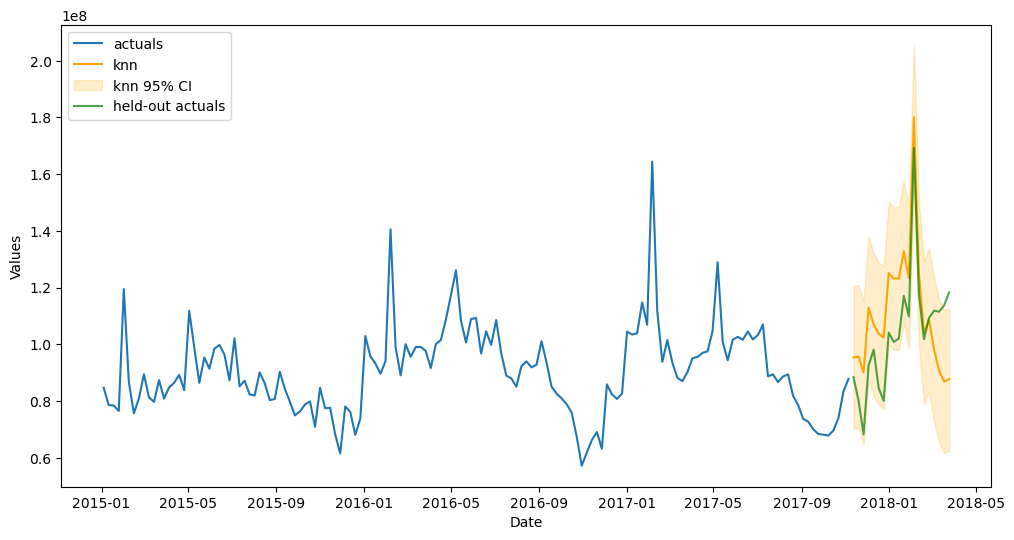

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
f.plot(ci=True,models='top_1',order_by='TestSetRMSE',ax=ax)
sns.lineplot(
    y = 'Total Volume',
    x = 'Date',
    data = volume_sep.reset_index(),
    ax = ax,
    label = 'held-out actuals',
    color = 'green',
    alpha = 0.7,
)
plt.show()

In [36]:
avc_fcsts1 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    results_template.copy(),
    avc_fcsts1,
    'Avocados',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Avocados
mlr,8.36
elasticnet,7.59
ridge,7.63
knn,8.21
xgboost,13.07
lightgbm,19.81
gbt,9.62


In [37]:
results['Avocados'] = avc_results['Avocados']
results

,Daily Visitors,Housing Starts,Avocados
mlr,5.63,5.66,8.36
elasticnet,5.59,8.24,7.59
ridge,5.61,7.30,7.63
knn,5.63,6.79,8.21
xgboost,5.52,3.92,13.07
lightgbm,5.20,4.29,19.81
gbt,8.34,12.67,9.62


## All Aggregated Results

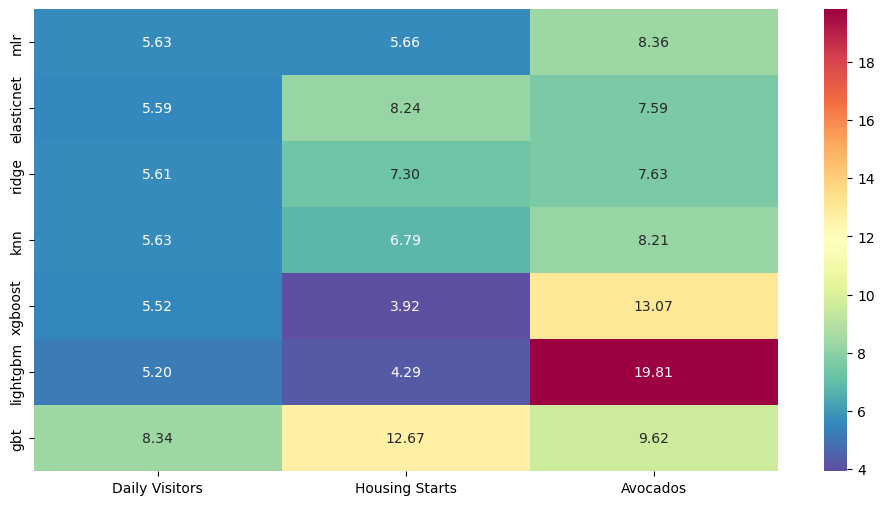

In [38]:
_, ax = plt.subplots(figsize=(12,6))
sns.heatmap(
    results,
    annot=True,
    fmt='.2f',
    cmap="Spectral_r",
    ax=ax
)
plt.show()

For the most part, the linear models set the best intervals and the boosted tree models were very good or very bad, with GBT more towards the bad side.

## Benchmark Against StatsModels ARIMA
- Confidence intervals come from StatsModels but the auto-ARIMA process is from [PMDARIMA](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima).

In [39]:
from scalecast.auxmodels import auto_arima

In [40]:
all_series = {
    # series,out-of-sample series,seasonal step
    'visitors':[visits,visits_sep,1],
    'housing starts':[starts,starts_sep,12],
    'avocados':[volume,volume_sep,1]
}
arima_conformal_results = pd.DataFrame()
arima_sm_results = pd.DataFrame()

In [41]:
for k, v in all_series.items():
    print(k)
    f = Forecaster(
        y=v[0],
        current_dates=v[0].index,
        future_dates=len(v[1]),
        test_length = len(v[1]),
        cis=True,
    )
    auto_arima(f,m=v[2])
    arima_results = f.export("lvl_fcsts",cis=True)
    # scalecast intervals
    arima_conformal_results.loc[k,'MSIS'] = metrics.msis(
        a = v[1].values,
        uf = arima_results['auto_arima_upperci'].values,
        lf = arima_results['auto_arima_lowerci'].values,
        obs = v[0].values,
        m = v[2],
    )
    # statsmodels intervals
    cis = f.regr.get_forecast(len(v[1])).conf_int()
    arima_sm_results.loc[k,'MSIS'] = metrics.msis(
        a = v[1].values,
        uf = cis.T[1],
        lf = cis.T[0],
        obs = v[0].values,
        m = v[2],
    )

visitors


/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.po

housing starts


/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


avocados


/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/uger7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.po

### MSIS Results - ARIMA Scalecast

In [42]:
# results from the scalecast intervals
arima_conformal_results

,MSIS
visitors,4.97
housing starts,24.90
avocados,23.15


In [43]:
arima_conformal_results.mean()

MSIS   17.68
dtype: float64

### MSIS Results - ARIMA StatsModels

In [44]:
# results from the statsmodels intervals
arima_sm_results

,MSIS
visitors,5.84
housing starts,5.62
avocados,19.94


In [45]:
arima_sm_results.mean()

MSIS   10.47
dtype: float64

In [46]:
all_results = results.copy()
all_results.loc['arima (conformal)'] =  arima_conformal_results.T.values[0]
all_results.loc['arima (statsmodels) - benchmark'] = arima_sm_results.T.values[0]
all_results = all_results.T
all_results

,mlr,elasticnet,ridge,knn,xgboost,lightgbm,gbt,arima (conformal),arima (statsmodels) - benchmark
Daily Visitors,5.63,5.59,5.61,5.63,5.52,5.20,8.34,4.97,5.84
Housing Starts,5.66,8.24,7.30,6.79,3.92,4.29,12.67,24.90,5.62
Avocados,8.36,7.59,7.63,8.21,13.07,19.81,9.62,23.15,19.94


In [47]:
def highlight_rows(row):
    ret_row = ['']*all_results.shape[1]
    for i, c in enumerate(all_results.iloc[:,:-1]):
        if row[c] < row['arima (statsmodels) - benchmark']:
            ret_row[i] = 'background-color: lightgreen;'
        else:
            ret_row[i] = 'background-color: lightcoral;'
    return ret_row

all_results.style.apply(
    highlight_rows,
    axis=1,
)

,mlr,elasticnet,ridge,knn,xgboost,lightgbm,gbt,arima (conformal),arima (statsmodels) - benchmark
Daily Visitors,5.632456,5.594578,5.609157,5.626693,5.520301,5.196714,8.337301,4.974750,5.837897
Housing Starts,5.657050,8.238805,7.299241,6.788912,3.924839,4.289493,12.670211,24.899395,5.624759
Avocados,8.358805,7.589377,7.632794,8.206887,13.069660,19.810258,9.621282,23.151315,19.944485


The above table shows which scalecast intervals performed better or worse than the ARIMA interval. Green scores are better, red are worse. The scalecast conformal intervals were on the whole better, but not always. When comparing ARIMA to ARIMA, the confidence intervals from statsmodels performed slightly worse on one series, slightly better on another, and significantly better on the remaining one. The rest of the models run through scalecast usually beat the ARIMA intervals on all datasets, except housing starts. XGBoost and Lightgbm were the only models to always beat the intervals from StatsModels. On the whole, the scalecast interval has a nice showing against the more traditional interval from ARIMA in the StatsModels package.